<a href="https://colab.research.google.com/github/Adlucent/ga4-churn-prediction/blob/main/II_Array_Flattening_and_EDA_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II. Array Column Flattening & EDA Part 2

In this notebook, we'll begin initial steps to prepare the data for modeling. We'll flatten and inspect the array columns from the sample dataset.

1. Starting with the original sample dataset, import data from BQ for users who have made **at least one purchase**
2. Drop columns where all rows are null or all have the same value
3. Flatten that df using a Python script and several SQL queries (note that we'll save several interim tables to BigQuery along the way to make it easier to go back to certain steps later if needed)
4. Perform EDA on the new flattened file
5. Save df to BigQuery <br>

**IMPORTANT NOTE**: Throughout this notebook, there are several steps where we save interim checkpoint tables to BigQuery. If your notebook hits its RAM limit and crashes, you can pick up where you left off by importing the table from the last step you finished. <br>

Here is a reference for each interim saved table by name: <br>
* churn_ga4_2a: table containing data only for users who have made at least one purchase before.
* churn_ga4_2b: unnested event_params table
* churn_ga4_2c: unnested privacy_info, user_properties if non-null values exist, user_ltv, device, geo, traffic source, and ecommerce
* churn_ga4_2d: unnested items table
* churn_ga4_2e: joins 2b and 2c
* churn_ga4_2f: joins 2d and 2e

Another option if you have a large dataset is to [upgrade your Colab runtime](https://colab.research.google.com/signup) or [connect to a local runtime](https://research.google.com/colaboratory/local-runtimes.html). 

## Import libraries

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'adl-analytics' #add proj name
region = "US"  # GCP project region

In [ ]:
# Google credentials 
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics 
'''BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI '''

from google.cloud import bigquery
from google.cloud.bigquery import magics, Client, QueryJobConfig

magics.context.project = project_name
client = bigquery.Client(project=magics.context.project)

# data processing libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# suppress notebook warnings
import warnings
warnings.filterwarnings('ignore')

# dataframe formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Import data from BigQuery for users who have made at least one purchase (churn_ga4_2a)

Note: Import from the original dataset since we only analyzed a sample in the last notebook due to its size.

In [ ]:
%%bigquery --project $project_name

CREATE OR REPLACE TABLE `adl-analytics.public_sample_data.churn_ga4_2a` #update with your project and dataset name
AS
WITH events AS (
    SELECT * 
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` #update with your project and dataset name
), target_users AS (
    SELECT
         user_pseudo_id,
    FROM
      (
        SELECT
          user_pseudo_id,
          ARRAY_AGG(STRUCT(event_name)) AS event_list
        FROM
          `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` 
        GROUP BY
          user_pseudo_id
      ),
      UNNEST(event_list) AS EL
    WHERE
      "purchase" IN (SELECT event_name FROM UNNEST(event_list))
    GROUP BY
        user_pseudo_id
)
SELECT e.*
FROM events e
LEFT JOIN target_users k
ON e.user_pseudo_id = k.user_pseudo_id
WHERE k.user_pseudo_id IS NOT NULL
ORDER BY user_pseudo_id

Query is running:   0%|          |

""


Import churn_ga4_2a as a dataframe.

In [ ]:
%%bigquery df --project $project_name

SELECT * 
FROM `adl-analytics.public_sample_data.churn_ga4_2a` #update your project and dataset name here

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.shape

(778146, 23)

The table has 778,146 rows and 23 columns.

In [ ]:
df1 = df[["user_pseudo_id", "event_date","event_timestamp","event_name","event_params"]].copy()

In [ ]:
df1 = df1.explode("event_params")


### Save interim table to BigQuery (churn_ga4_2b)

In [ ]:
client = bigquery.Client(project = project_name)
table_id = 'adl-analytics.public_sample_data.churn_ga4_2b'

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df1, table_id, job_config=job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=22e57b09-82e7-4fd4-bafb-db57fcb44d3c>

# Flatten array columns

### 1) event_params

*I'm re-importing the above table here because my runtime crashes before completing the next section.*

In [ ]:
%%bigquery df1 --project $project_name

SELECT * 
FROM `adl-analytics.public_sample_data.churn_ga4_2b` #update your project and dataset name here

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# check first five rows
df1.head()

,user_pseudo_id,event_date,event_timestamp,event_name,event_params,__index_level_0__
0,39887388.4118342505,20201210,1607613604332628,add_payment_info,"{'key': 'currency', 'value': {'double_value': ...",28
1,4055961.2903422421,20201223,1608742008349851,user_engagement,"{'key': 'gclsrc', 'value': {'double_value': No...",72
2,41038964.1300925220,20201214,1607951544803784,page_view,"{'key': 'entrances', 'value': {'double_value':...",124
3,41025522.7163055341,20201211,1607685521395539,purchase,"{'key': 'tax', 'value': {'double_value': 7.88,...",470
4,41025522.7163055341,20201211,1607685521395539,purchase,"{'key': 'transaction_id', 'value': {'double_va...",470


In [ ]:
# unnest event_params
FIELDS = [
    "key", 
    "value.double_value", 
    "value.string_value", 
    "value.int_value", 
    "value.float_value", 
    ]

df_t = pd.json_normalize(df1["event_params"])[FIELDS]

In [ ]:
# check first five rows
df_t.head()

,key,value.double_value,value.string_value,value.int_value,value.float_value
0,transaction_id,NaN,9056249662,NaN,None
1,payment_type,NaN,Pay with credit card,NaN,None
2,search_term,NaN,<obfuscated>,NaN,None
3,value,NaN,None,84.000,None
4,search_term,NaN,<obfuscated>,NaN,None


In [ ]:
# left join df_t columns onto original df
df1 = df1.join(df_t)

In [ ]:
# drop original event_params col and extra index column
df1.drop(["event_params","__index_level_0__"], axis = 1, inplace = True)

In [ ]:
# check top of df one more time
df1.head()

,user_pseudo_id,event_date,event_timestamp,event_name,key,value.double_value,value.string_value,value.int_value,value.float_value
0,39887388.4118342505,20201210,1607613604332628,add_payment_info,currency,NaN,USD,NaN,None
1,4055961.2903422421,20201223,1608742008349851,user_engagement,gclsrc,NaN,None,NaN,None
2,41038964.1300925220,20201214,1607951544803784,page_view,entrances,NaN,None,1.000,None
3,41025522.7163055341,20201211,1607685521395539,purchase,tax,7.880,None,NaN,None
4,41025522.7163055341,20201211,1607685521395539,purchase,transaction_id,NaN,9946092703,NaN,None


In [ ]:
# create foreign_key by concatenating event_timstamp and event_name with a bar delimiter 
df1["foreign_key"] = df1['event_timestamp'].astype(str) +"|"+ df1["event_name"]

In [ ]:
# consolidate value columns into one and delete original values
df1["value"] = df1['value.double_value'].fillna(df1['value.int_value'])
df1["value"] = df1['value'].fillna(df1['value.string_value'])
df1.drop([
    #"float_value", 
    "value.string_value", 
    "value.int_value", 
    "value.double_value"
    ], axis = 1, inplace = True)

In [ ]:
df1.head()

,user_pseudo_id,event_date,event_timestamp,event_name,key,value.float_value,foreign_key,value
0,39887388.4118342505,20201210,1607613604332628,add_payment_info,currency,None,1607613604332628|add_payment_info,USD
1,4055961.2903422421,20201223,1608742008349851,user_engagement,gclsrc,None,1608742008349851|user_engagement,None
2,41038964.1300925220,20201214,1607951544803784,page_view,entrances,None,1607951544803784|page_view,1.000
3,41025522.7163055341,20201211,1607685521395539,purchase,tax,None,1607685521395539|purchase,7.880
4,41025522.7163055341,20201211,1607685521395539,purchase,transaction_id,None,1607685521395539|purchase,9946092703


In [ ]:
# pivot key and populate with values column
df1_pivot = df1.pivot(index='foreign_key',columns='key',values='value').reset_index()

In [ ]:
# convert to dataframe
df1_pivot = pd.DataFrame(df1_pivot)

In [ ]:
# drop columns where all row values are null
df1_pivot.dropna(how='all', axis=1, inplace = True)

In [ ]:
df1_pivot.head()

key,foreign_key,campaign,clean_event,coupon,currency,debug_mode,engaged_session_event,engagement_time_msec,entrances,ga_session_id,ga_session_number,link_classes,link_domain,link_url,medium,outbound,page_location,page_referrer,page_title,payment_type,percent_scrolled,promotion_name,search_term,session_engaged,shipping_tier,source,tax,term,transaction_id,unique_search_term,value
0,1604189395117321|first_visit,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1604189395117321|page_view,NaN,gtm.js,NaN,NaN,1.000,1.000,NaN,1.000,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1604189395117321|session_start,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1604189404046100|user_engagement,NaN,gtm.js,NaN,NaN,1.000,1.000,8919.000,NaN,6944996097.000,1.000,NaN,NaN,NaN,NaN,NaN,https://shop.googlemerchandisestore.com/Google...,NaN,Men's / Unisex | Apparel | Google Merchandise ...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1604189409521919|page_view,<Other>,gtm.js,NaN,NaN,1.000,1.000,NaN,NaN,6944996097.000,1.000,NaN,NaN,NaN,<Other>,NaN,https://shop.googlemerchandisestore.com/Google...,None,Apparel | Google Merchandise Store,NaN,NaN,NaN,NaN,1,NaN,<Other>,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1_pivot.dtypes

key
foreign_key              object
campaign                 object
clean_event              object
coupon                   object
currency                 object
debug_mode               object
engaged_session_event    object
engagement_time_msec     object
entrances                object
ga_session_id            object
ga_session_number        object
link_classes             object
link_domain              object
link_url                 object
medium                   object
outbound                 object
page_location            object
page_referrer            object
page_title               object
payment_type             object
percent_scrolled         object
promotion_name           object
search_term              object
session_engaged          object
shipping_tier            object
source                   object
tax                      object
term                     object
transaction_id           object
unique_search_term       object
value                    object
dtyp

Save the latest df to a .csv and then-reimport to ensure the data types are combatible with uploading to BigQuery.

In [ ]:
df1_pivot.to_csv('df1_pivot.csv', encoding='utf-8', index=False)

In [ ]:
df_for_bq = pd.read_csv("df1_pivot.csv", encoding="utf-8", low_memory=False)

In [ ]:
df_for_bq.dtypes

foreign_key               object
campaign                  object
clean_event               object
coupon                   float64
currency                  object
debug_mode               float64
engaged_session_event    float64
engagement_time_msec     float64
entrances                float64
ga_session_id             object
ga_session_number        float64
link_classes              object
link_domain               object
link_url                  object
medium                    object
outbound                  object
page_location             object
page_referrer             object
page_title                object
payment_type              object
percent_scrolled         float64
promotion_name            object
search_term               object
session_engaged          float64
shipping_tier             object
source                    object
tax                      float64
term                      object
transaction_id           float64
unique_search_term       float64
value     

### Save updates to overwrite event_params BQ table with latest updates (churn_ga4_2b).

In [ ]:
client = bigquery.Client(project = project_name)
table_id = 'public_sample_data.churn_ga4_2b' #update with your project and dataset name
    
job_config = bigquery.LoadJobConfig(
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df_for_bq, table_id, job_config = job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=377ec1e6-d94c-4e99-beda-aeb0a7e6dc90>

### 2) Unnest `privacy_info`, `user_properties` if non-null values exist, `user_ltv`, `device`, `geo`, `traffic source`, and `ecommerce` (churn_ga4_2c)

In [ ]:
%%bigquery --project $project_name

CREATE OR REPLACE TABLE `adl-analytics.public_sample_data.churn_ga4_2c` #update with your project and dataset name
AS
SELECT
    CONCAT(event_timestamp,'|',event_name) AS pk, --Concatenate this field to make a unique private key
    event_date, 
    event_timestamp, -- Foreign Key for linking flattened data to existing table
    event_name,
    event_previous_timestamp,     
    event_value_in_usd,
    event_bundle_sequence_id,     
    event_server_timestamp_offset,
    user_id,
    user_pseudo_id,
    --privacy_info (un-nest)
    privacy_info.analytics_storage as privacy_info_analytics_storage,
    privacy_info.ads_storage as privacy_info_ads_storage,
    privacy_info.uses_transient_token as privacy_info_uses_transient_token,
    --user_properties (removed as fields are null),
    user_first_touch_timestamp, 
    --user_ltv (un-nest)
    user_ltv.revenue as user_ltv_revenue,
    user_ltv.currency as user_ltv_currency,
    --device (un-nest)
    device.category as device_category,
    device.mobile_brand_name as device_mobile_brand_name,
    device.mobile_model_name as device_mobile_model_name,
    device.mobile_marketing_name as device_mobile_marketing_name,
    device.mobile_os_hardware_model as device_mobile_os_hardware_model,
    device.operating_system as device_operating_system,
    device.operating_system_version as device_operating_system_version,
    device.vendor_id as device_vendor_id,
    device.advertising_id as device_advertising_id,
    device.language as device_language,
    device.is_limited_ad_tracking as device_is_limited_ad_tracking,
    device.time_zone_offset_seconds as device_time_zone_offset_seconds,
    device.web_info.browser as device_web_info_browser,
    device.web_info.browser_version as device_web_info_browser_version,
    --geo (un-nest)
    geo.continent as geo_continent,
    geo.sub_continent as geo_sub_continent,
    geo.country as geo_country,
    geo.region as geo_region, 
    geo.city as geo_city,
    geo.metro as geo_metro,
    app_info.id as app_info_id,
    app_info.version as app_info_version,
    app_info.install_store as app_info_install_store,
    app_info.firebase_app_id as app_info_firebase_app_id,
    app_info.install_source as app_info_install_source,
    --traffic_source (un-nest)
    traffic_source.medium as traffic_source_medium,
    traffic_source.name as traffic_source_name,
    traffic_source.source as traffic_source_source,
    stream_id,
    platform,
    event_dimensions.hostname as event_dimensions_hostname,
    --ecommerce
    ecommerce.total_item_quantity as ecommerce_total_item_quantity,
    ecommerce.purchase_revenue_in_usd as ecommerce_purchase_revenue_in_usd,
    ecommerce.purchase_revenue as ecommerce_purchase_revenue,
    ecommerce.refund_value_in_usd as ecommerce_refund_value_in_usd,
    ecommerce.refund_value as ecommerce_refund_value,
    ecommerce.shipping_value_in_usd as ecommerce_shipping_value_in_usd,
    ecommerce.shipping_value as ecommerce_shipping_value,
    ecommerce.tax_value_in_usd as ecommerce_tax_value_in_usd,
    ecommerce.tax_value as ecommerce_tax_value,
    ecommerce.unique_items as ecommerce_unique_items,
    ecommerce.transaction_id as ecommerce_transaction_id
FROM
    `adl-analytics.public_sample_data.churn_ga4_2a` #update with your project and dataset name from 2a

Query is running:   0%|          |

""


### 3) Unnest `items` (churn_ga4_2d)

In [ ]:
%%bigquery --project $project_name

--ITEMS
CREATE OR REPLACE TABLE `adl-analytics.public_sample_data.churn_ga4_2d` #update with your project and dataset name
AS
SELECT
CONCAT(event_timestamp,'|',event_name) AS pk, --Concatenate this field to make a unique pk
    items.item_id as items_item_id,
    items.item_name as items_item_name,
    items.item_brand as items_item_brand,
    items.item_variant as items_item_variant,
    items.item_category as items_item_category,
    items.item_category2 as items_item_category2,
    items.item_category3 as items_item_category3,
    items.item_category4 as items_item_category4,
    items.item_category5 as items_item_category5,
    items.price_in_usd as items_price_in_usd,
    items.price as items_price,
    items.quantity as items_quantity,
    items.item_revenue_in_usd as items_item_revenue_in_usd,   
    items.item_revenue as items_item_revenue,
    items.item_refund_in_usd as items_item_refund_in_usd,
    items.item_refund as items_item_refund,
    items.coupon as items_coupon,
    items.affiliation as items_affialition,
    items.location_id as items_location_id,
    items.item_list_id as items_item_list_id,
    items.item_list_name as items_item_list_name,
    items.item_list_index as items_item_list_index,
    items.promotion_id as items_promotion_id,
    items.promotion_name as items_promotion_name,
    items.creative_name as items_creative_name,
    items.creative_slot as items_creative_slot
FROM
    `adl-analytics.public_sample_data.churn_ga4_2a`, UNNEST(items) as items #update with your project and dataset name from 2a

Query is running:   0%|          |

""


### 4) Join the unnested event_params table and the second unnested table containing all fields except items (churn_ga4_2e)

In [ ]:
%%bigquery --project $project_name

CREATE OR REPLACE TABLE `adl-analytics.public_sample_data.churn_ga4_2e` #update with your project and dataset name
AS
SELECT a.*, b.* FROM `adl-analytics.public_sample_data.churn_ga4_2c` as a #update with your project and dataset name
INNER JOIN `adl-analytics.public_sample_data.churn_ga4_2b` as b #update with your project and dataset name
ON a.pk = b.foreign_key;

Query is running:   0%|          |

""


### 5) Join the above table and the items table to create our final dataset

In [ ]:
%%bigquery --project $project_name

CREATE OR REPLACE TABLE `adl-analytics.public_sample_data.churn_ga4_2f` #update with your project and dataset name
AS
SELECT a.*,
b.items_item_id,
b.items_item_name,
b.items_item_brand,
b.items_item_variant,
b.items_item_category,
b.items_item_category2,
b.items_item_category3,
b.items_item_category4,
b.items_item_category5,
b.items_price_in_usd,
b.items_price,
b.items_quantity,
b.items_item_revenue_in_usd,
b.items_item_revenue,
b.items_item_refund_in_usd,
b.items_item_refund,
b.items_coupon,
b.items_affialition,
b.items_location_id,
b.items_item_list_id,
b.items_item_list_name,
b.items_item_list_index,
b.items_promotion_id,
b.items_promotion_name,
b.items_creative_name,
b.items_creative_slot
FROM `adl-analytics.public_sample_data.churn_ga4_2e` as a 
FULL OUTER JOIN `adl-analytics.public_sample_data.churn_ga4_2d` as b
ON a.pk = b.pk;

Query is running:   0%|          |

""


I'm re-importing the table above because my runtime hit its max RAM.

In [ ]:
%%bigquery df --project $project_name

SELECT *
FROM `adl-analytics.public_sample_data.churn_ga4_2f` #update with your project and dataset name

Query is running:   0%|          |

Downloading:   0%|          |

## Inspect the flattened data

In [ ]:
df.shape

(2002257, 115)

The flattened dataset has 2,002,257 rows and 115 columns.

In [ ]:
df.head()

,pk,event_date,event_timestamp,event_name,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,privacy_info_analytics_storage,privacy_info_ads_storage,privacy_info_uses_transient_token,user_first_touch_timestamp,user_ltv_revenue,user_ltv_currency,device_category,device_mobile_brand_name,device_mobile_model_name,device_mobile_marketing_name,device_mobile_os_hardware_model,device_operating_system,device_operating_system_version,device_vendor_id,device_advertising_id,device_language,device_is_limited_ad_tracking,device_time_zone_offset_seconds,device_web_info_browser,device_web_info_browser_version,geo_continent,geo_sub_continent,geo_country,geo_region,geo_city,geo_metro,app_info_id,app_info_version,app_info_install_store,app_info_firebase_app_id,app_info_install_source,traffic_source_medium,traffic_source_name,traffic_source_source,stream_id,platform,event_dimensions_hostname,ecommerce_total_item_quantity,ecommerce_purchase_revenue_in_usd,ecommerce_purchase_revenue,ecommerce_refund_value_in_usd,ecommerce_refund_value,ecommerce_shipping_value_in_usd,ecommerce_shipping_value,ecommerce_tax_value_in_usd,ecommerce_tax_value,ecommerce_unique_items,ecommerce_transaction_id,foreign_key,campaign,clean_event,coupon,currency,debug_mode,engaged_session_event,engagement_time_msec,entrances,ga_session_id,ga_session_number,link_classes,link_domain,link_url,medium,outbound,page_location,page_referrer,page_title,payment_type,percent_scrolled,promotion_name,search_term,session_engaged,shipping_tier,source,tax,term,transaction_id,unique_search_term,value,items_item_id,items_item_name,items_item_brand,items_item_variant,items_item_category,items_item_category2,items_item_category3,items_item_category4,items_item_category5,items_price_in_usd,items_price,items_quantity,items_item_revenue_in_usd,items_item_revenue,items_item_refund_in_usd,items_item_refund,items_coupon,items_affialition,items_location_id,items_item_list_id,items_item_list_name,items_item_list_index,items_promotion_id,items_promotion_name,items_creative_name,items_creative_slot
0,1608593429371242|view_item,20201221,1608593429371242,view_item,<NA>,NaN,802186744,<NA>,None,7070291.4775984721,<NA>,<NA>,No,1608593261154318,0.000,USD,desktop,Google,Chrome,<Other>,<NA>,Web,<Other>,<NA>,<NA>,en-us,No,<NA>,Chrome,86.0,Oceania,Australasia,Australia,South Australia,Adelaide,(not set),None,None,None,None,None,<Other>,<Other>,<Other>,2100450278,WEB,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,(not set),1608593429371242|view_item,<Other>,gtm.js,NaN,None,1.000,1.000,6763.000,NaN,2739105175.0,1.000,None,None,None,<Other>,<NA>,https://shop.googlemerchandisestore.com/Google...,https://shop.googlemerchandisestore.com/Google...,Apparel | Google Merchandise Store,None,NaN,None,None,1.000,None,<Other>,NaN,None,NaN,NaN,NaN,GGOEGXXX1340,Google Badge Heavyweight Pullover Black,(not set),(not set),Home/Apparel/,(not set),(not set),(not set),(not set),NaN,58.000,<NA>,NaN,NaN,NaN,NaN,(not set),(not set),(not set),(not set),(not set),9,(not set),(not set),(not set),(not set)
1,1607112967540040|select_item,20201204,1607112967540040,select_item,<NA>,NaN,2809256028,<NA>,None,7122244.8452189284,<NA>,<NA>,No,1594042783084890,0.000,USD,mobile,Apple,iPhone,<Other>,<NA>,Web,<Other>,<NA>,<NA>,en-us,No,<NA>,Safari,14.0,Americas,Northern America,United States,Michigan,(not set),(not set),None,None,None,None,None,referral,(referral),shop.googlemerchandisestore.com,2100450278,WEB,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,(not set),1607112967540040|select_item,None,gtm.js,NaN,None,1.000,1.000,1652.000,NaN,799545371.0,11.000,None,None,None,None,<NA>,https://shop.googlemerchandisestore.com/Google...,https://shop.googlemerchandisestore.com/basket...,Sale | Google Merchandise Store,None,NaN,None,None,1.000,None,None,NaN,None,NaN,NaN,NaN,GGOEACBA104599,Android SM S/F18 Sticker Sheet,(not set),(not set),Home/Sale/,(not set),(not set),(not set),(not set),NaN,3.000

In [ ]:
df.dtypes

pk                                    object
event_date                            object
event_timestamp                        Int64
event_name                            object
event_previous_timestamp               Int64
event_value_in_usd                   float64
event_bundle_sequence_id               Int64
event_server_timestamp_offset          Int64
user_id                               object
user_pseudo_id                        object
privacy_info_analytics_storage         Int64
privacy_info_ads_storage               Int64
privacy_info_uses_transient_token     object
user_first_touch_timestamp             Int64
user_ltv_revenue                     float64
user_ltv_currency                     object
device_category                       object
device_mobile_brand_name              object
device_mobile_model_name              object
device_mobile_marketing_name          object
device_mobile_os_hardware_model        Int64
device_operating_system               object
device_ope

The table has a combination of float64, int64, object and boolean data types.

In [ ]:
# check for null values
df.isnull().sum()

pk                                         0
event_date                                 0
event_timestamp                            0
event_name                                 0
event_previous_timestamp             2002257
event_value_in_usd                   1986702
event_bundle_sequence_id                   0
event_server_timestamp_offset        2002257
user_id                              2002257
user_pseudo_id                             0
privacy_info_analytics_storage       2002257
privacy_info_ads_storage             2002257
privacy_info_uses_transient_token          0
user_first_touch_timestamp             44823
user_ltv_revenue                           0
user_ltv_currency                          0
device_category                            0
device_mobile_brand_name                   0
device_mobile_model_name                   0
device_mobile_marketing_name               0
device_mobile_os_hardware_model      2002257
device_operating_system                    0
device_ope

There are quote a few columns where all values are null. Drop those before moving forward as they are not helpul in model building. 

In [ ]:
# drop columns where all rows are null
df.dropna(how='all', axis=1, inplace = True)

In [ ]:
df.shape

(2002257, 94)

The df has been reduced from 115 to 94 columns.
Next, drop any columns with only one unique value in the whole column.

In [ ]:
# drop columns with only one unique value
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis = 1, inplace = True)

In [ ]:
df.shape

(2002257, 66)

The df has been further reduced from 94 to 66 columns.

## Perform additional EDA on the flattened, reduced table

In [ ]:
# create lists of numeric and non-numeric columns
num_col = list(df.select_dtypes(include=np.number).columns)
obj_col = list(df.select_dtypes(['object']).columns)

### Numeric features

In [ ]:
# check for unique values in numeric features
for col in num_col:
    print(col)
    print(df[col].nunique())
    print("*" * 20)

event_timestamp
583744
********************
event_value_in_usd
342
********************
event_bundle_sequence_id
583711
********************
user_first_touch_timestamp
4311
********************
user_ltv_revenue
500
********************
ecommerce_total_item_quantity
73
********************
ecommerce_purchase_revenue_in_usd
343
********************
ecommerce_purchase_revenue
342
********************
ecommerce_tax_value_in_usd
55
********************
ecommerce_tax_value
55
********************
ecommerce_unique_items
27
********************
coupon
3
********************
engagement_time_msec
61025
********************
ga_session_number
62
********************
session_engaged
2
********************
tax
1386
********************
transaction_id
4918
********************
value
1554
********************
items_price_in_usd
68
********************
items_price
72
********************
items_quantity
45
********************
items_item_revenue_in_usd
165
********************
items_item_revenue
165
***

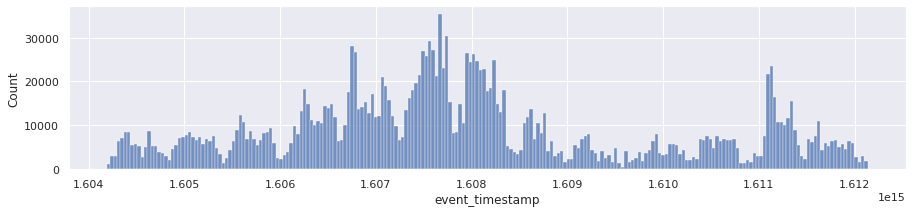

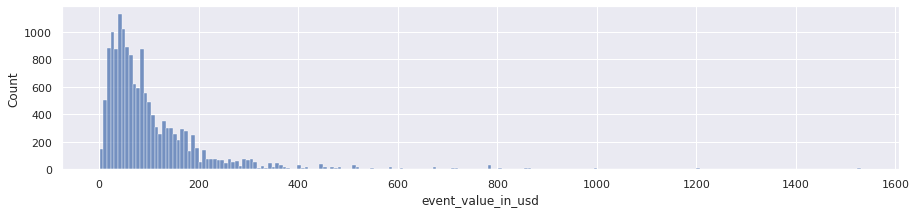

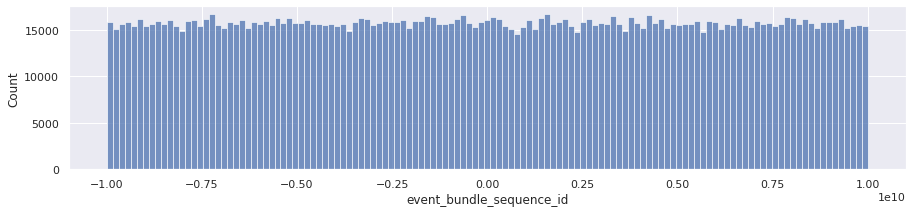

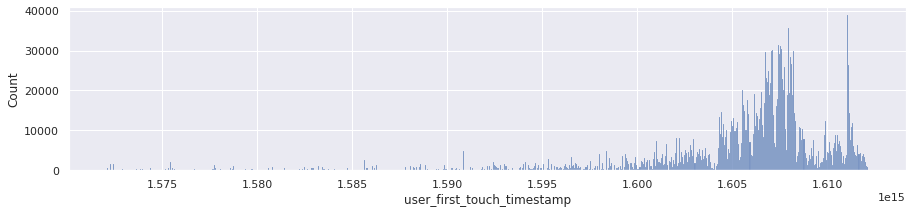

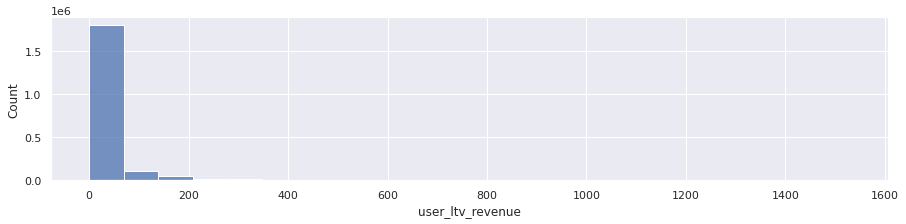

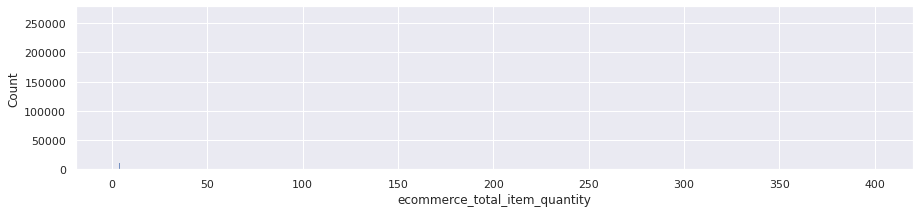

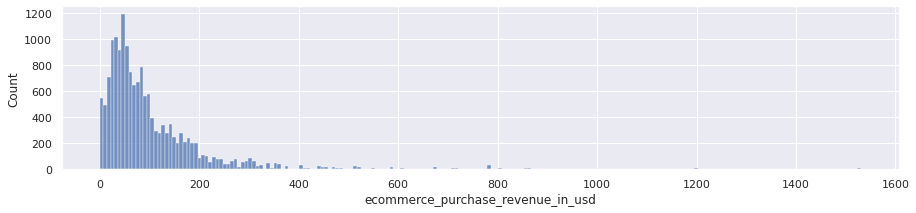

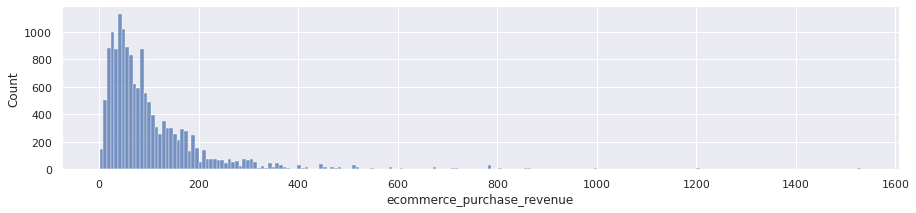

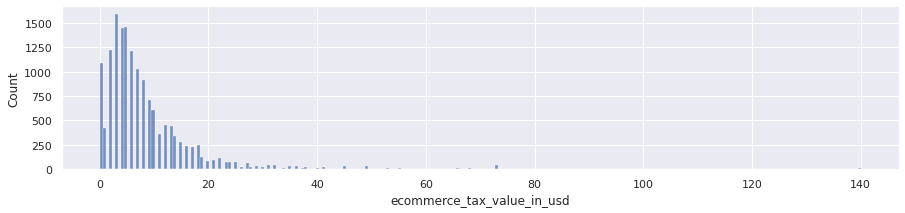

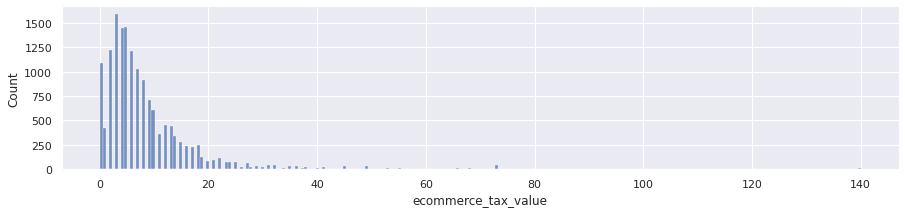

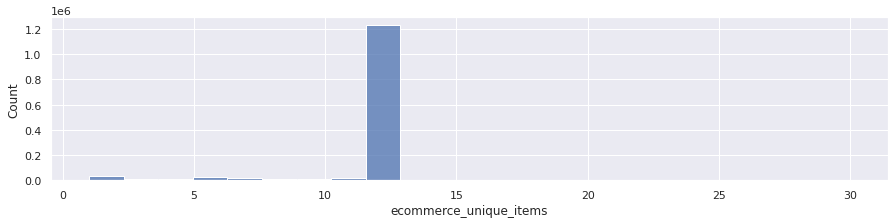

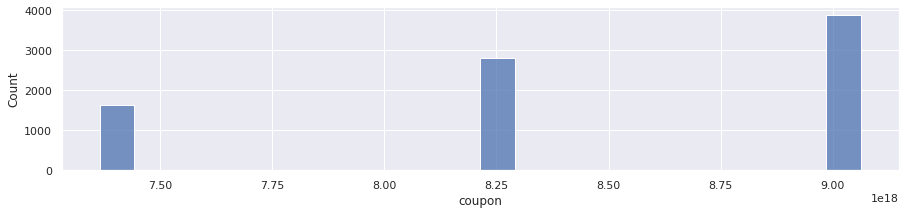

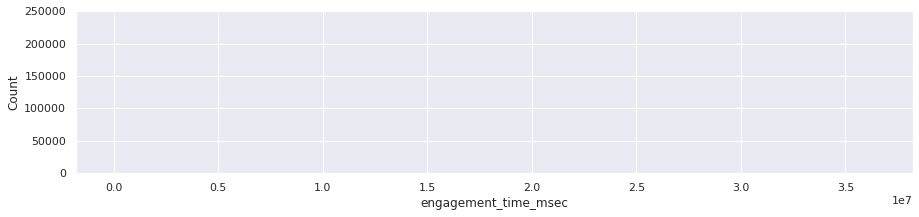

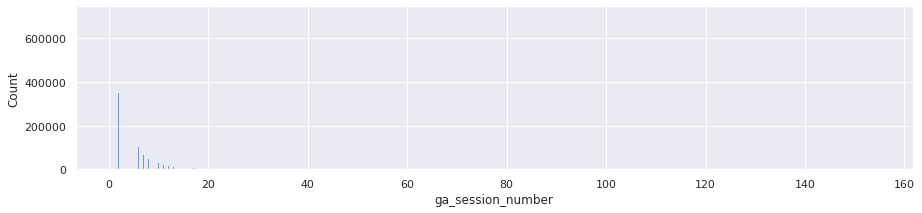

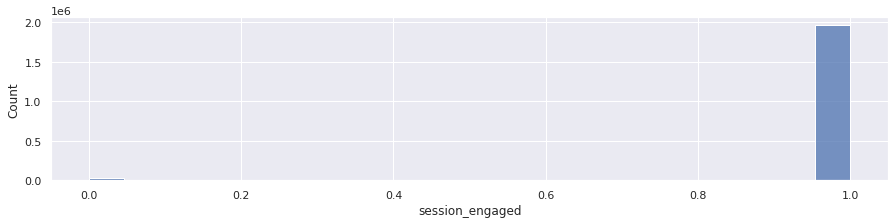

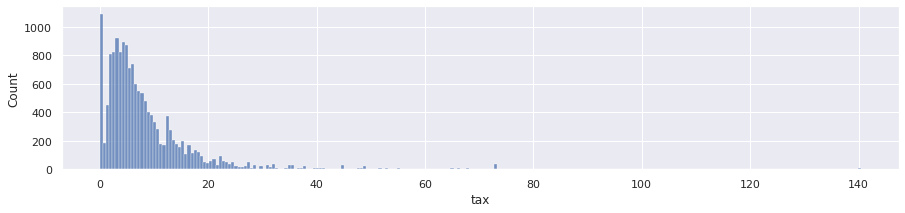

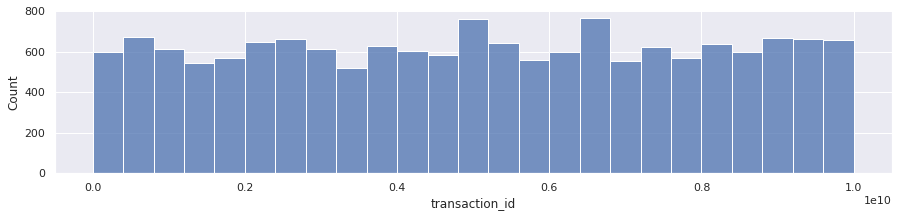

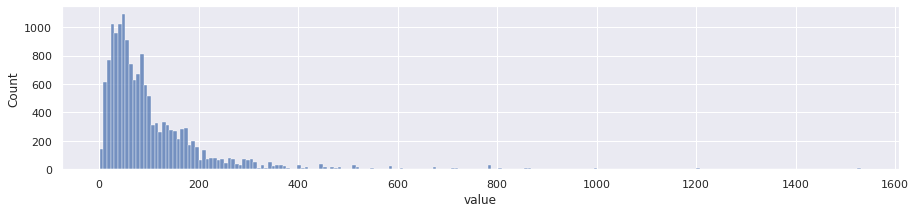

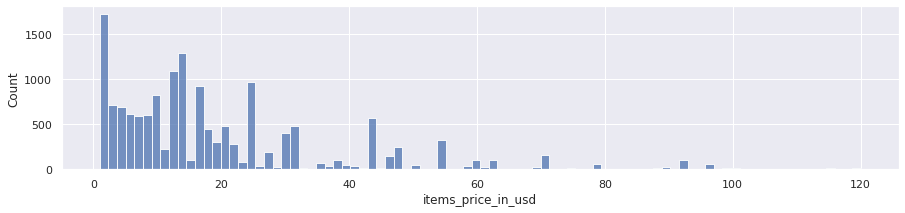

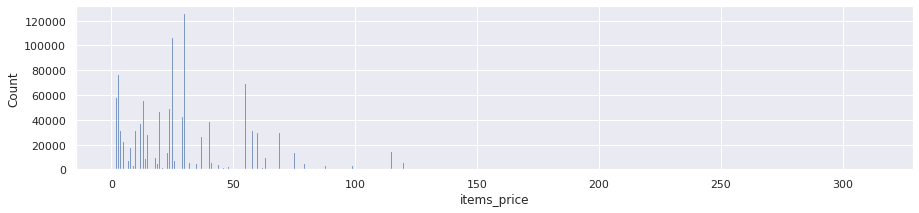

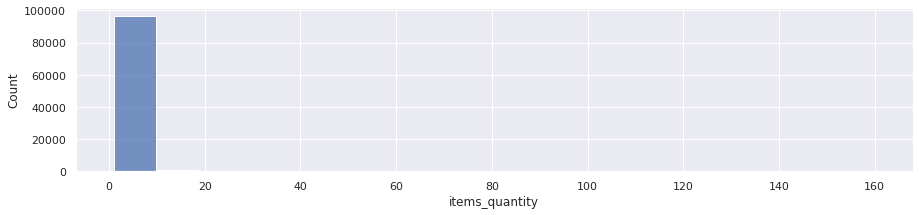

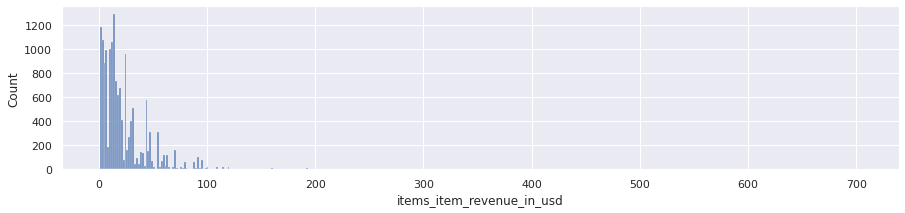

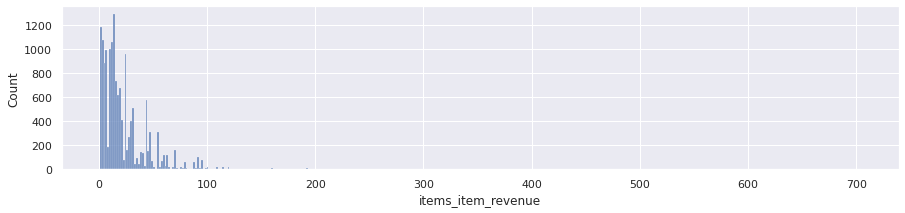

In [ ]:
# plot distributions of numeric features
for col in num_col:
    plt.figure(figsize=(15,3))
    sns.histplot(data = df,x = col)
    plt.show();

Of the numeric features above, the things that stand out are:
* Many of the columns are distributed as we'd expect (normal or almost normal distributions).
* `event_timestamp` is more linear as even though it's numeric it represents a time sequence feature
* `event_value_in_usd`, `ecommerce_purchase_revenue_in_usd`, `ecommerce_purchase_revenue`, and `value` have very similar (if not identical) distributions. These may be giving us duplicative information, which we'll keep in mind as we explore later steps.
* `event_bundle_sequence_id` appears to be distributed evenly across the chart. This makes sense as it's an id value rather than an actual numeric value.
* Most records for `user_ltv_revenue`, `items_quantity`, and `ecommerce_total_item_quantity` appear to fall very close to 1. 
* All of the tax value fields appear highly correlated with the revenue fields (as we'd expect). We may drop those later if too highly correlated. 
* `session_engaged` appears to only have values of 1, meaning this is likely representing a boolean feature.


Let's look at a correlation matrix as well for the numeric features.

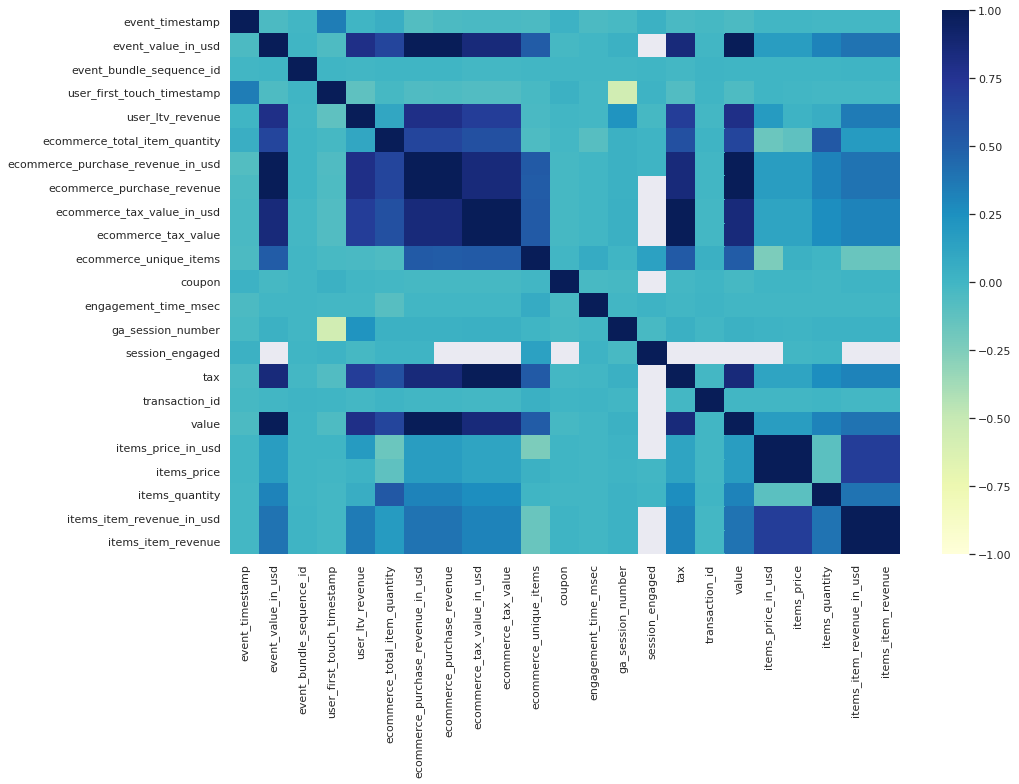

In [ ]:
corr = df[num_col].corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin = -1,
        vmax = 1,
        cmap = "YlGnBu")
plt.show();

As expected, many of the numeric features are highly correlated. We'll address this more in a later step when we analyze multicollinearity. 

### Non-numeric features

In [ ]:
# check for unique values in non-numeric features
for col in obj_col:
    print(col)
    print(df[col].nunique())
    print("*" * 20)

pk
778146
********************
event_date
92
********************
event_name
16
********************
user_pseudo_id
4419
********************
device_category
3
********************
device_mobile_brand_name
8
********************
device_mobile_model_name
10
********************
device_operating_system
6
********************
device_operating_system_version
11
********************
device_language
9
********************
device_web_info_browser
6
********************
device_web_info_browser_version
10
********************
geo_continent
6
********************
geo_sub_continent
19
********************
geo_country
101
********************
geo_region
316
********************
geo_city
511
********************
traffic_source_medium
6
********************
traffic_source_name
5
********************
traffic_source_source
5
********************
ecommerce_transaction_id
4452
********************
foreign_key
778146
********************
campaign
12
********************
ga_session_id
15723
**************

Start by plotting non-numeric features with a manageable number of unique values, we'll say 50 for now.

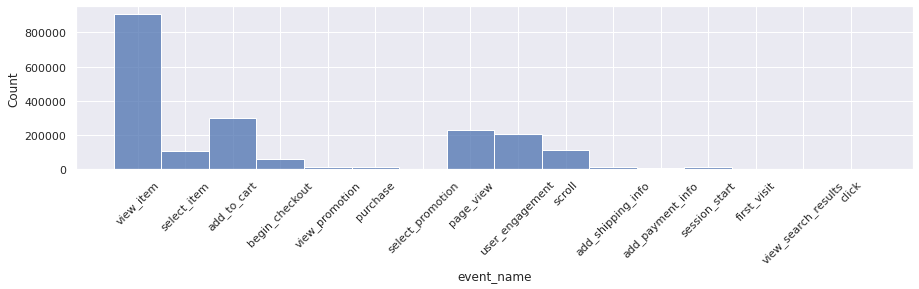

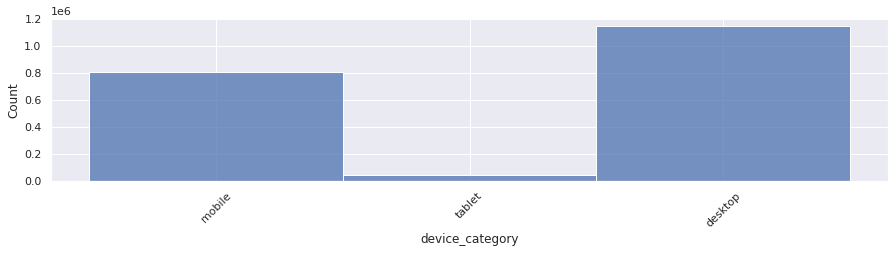

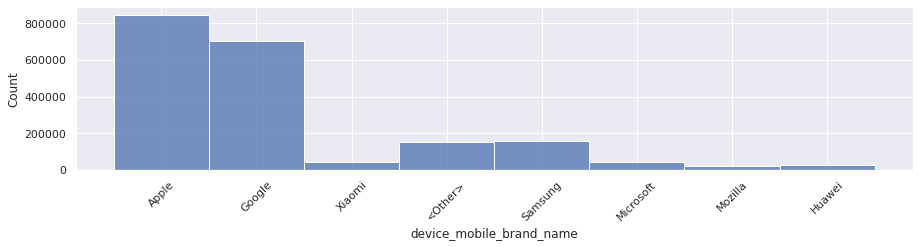

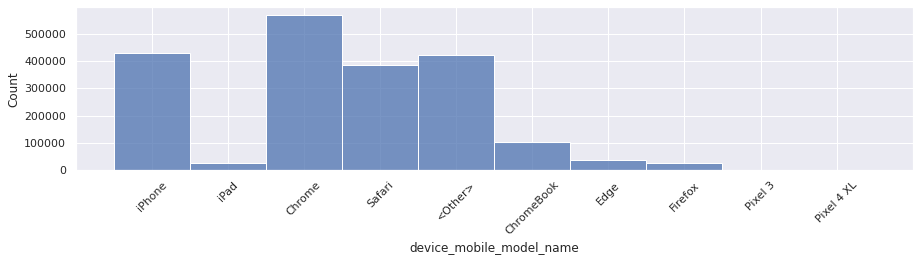

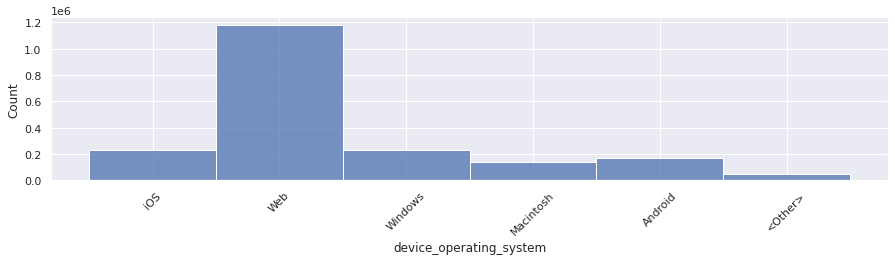

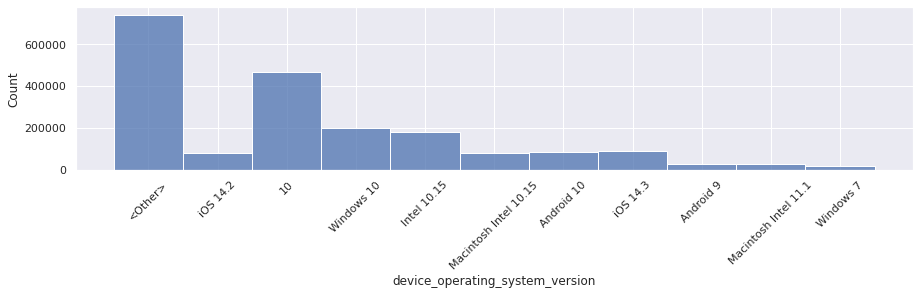

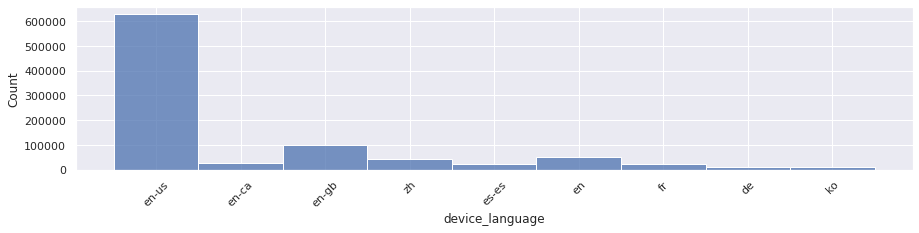

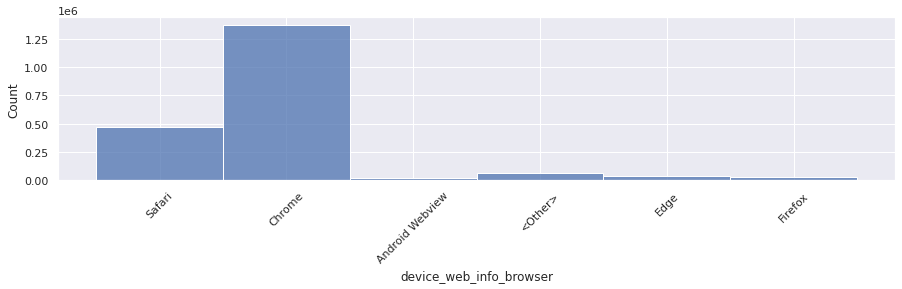

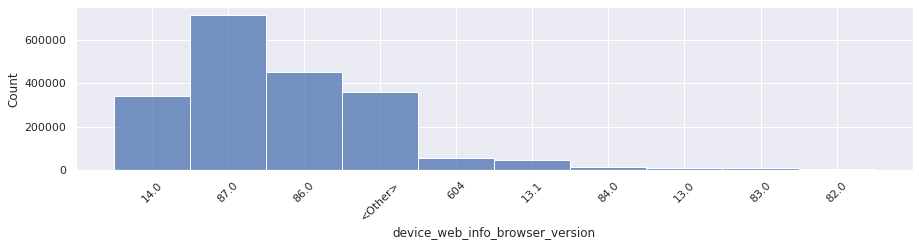

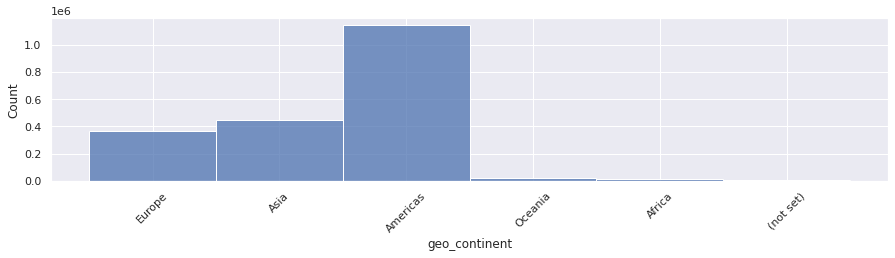

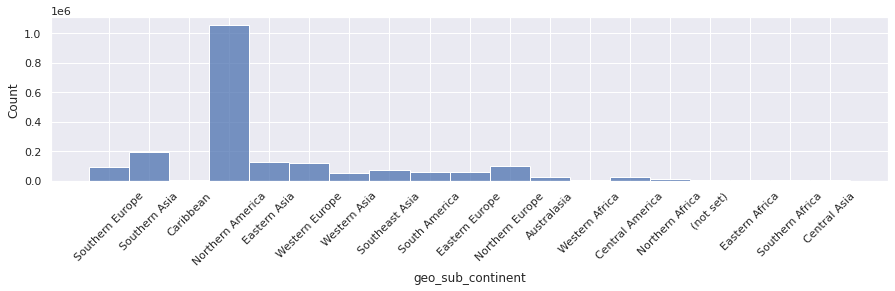

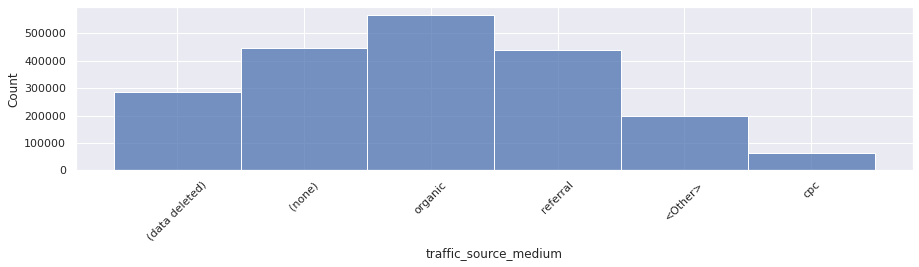

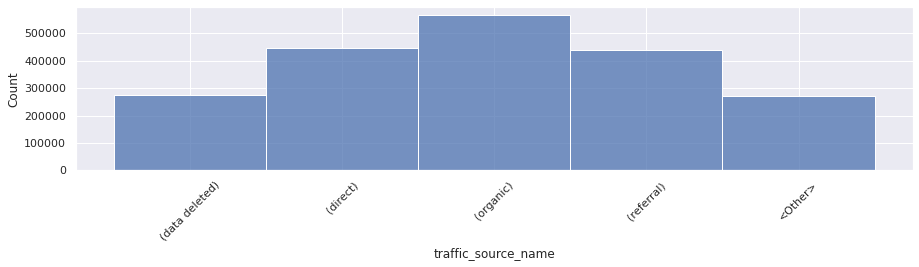

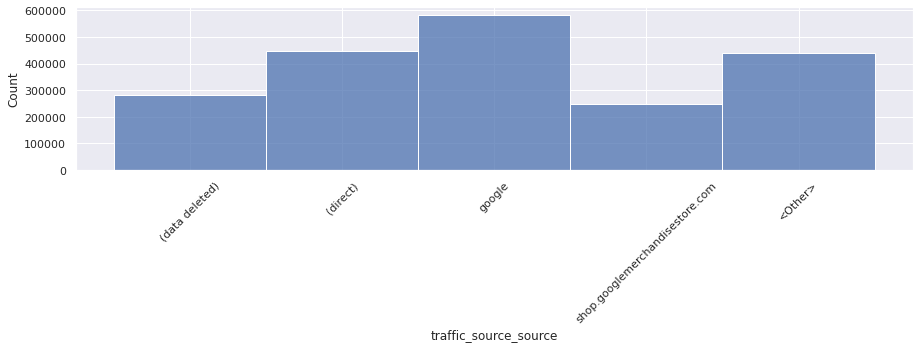

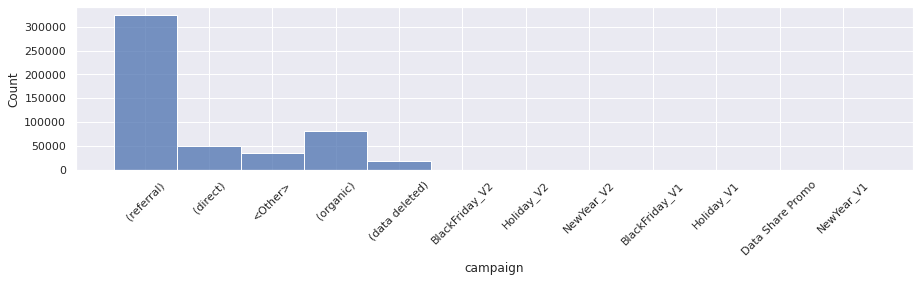

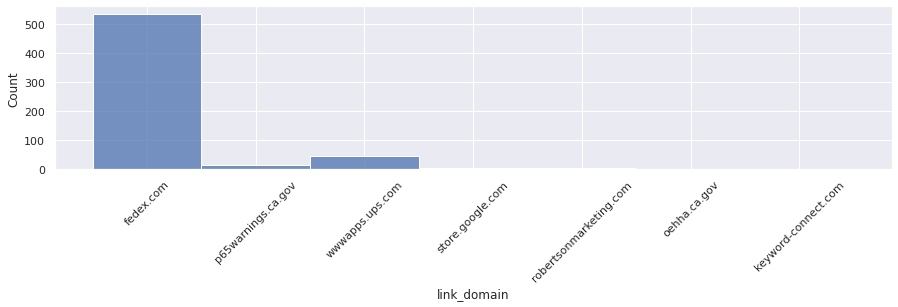

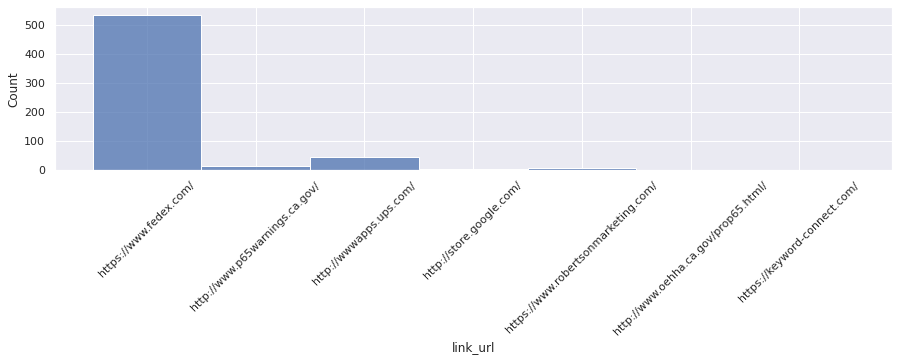

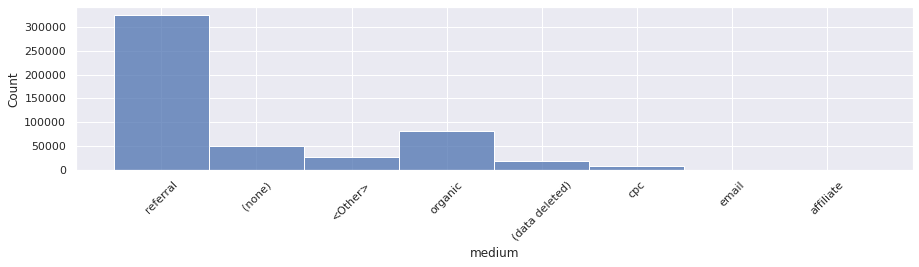

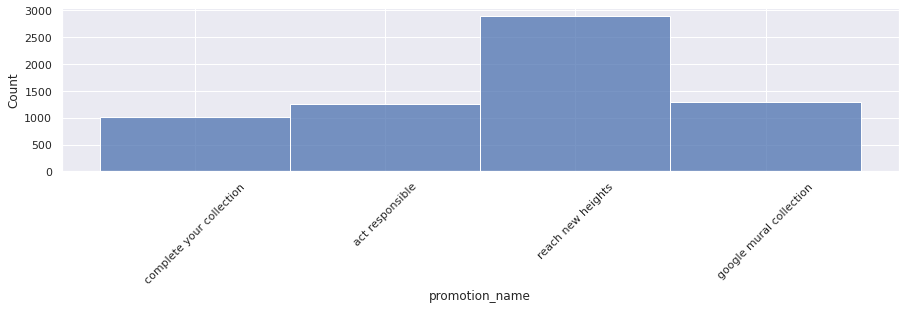

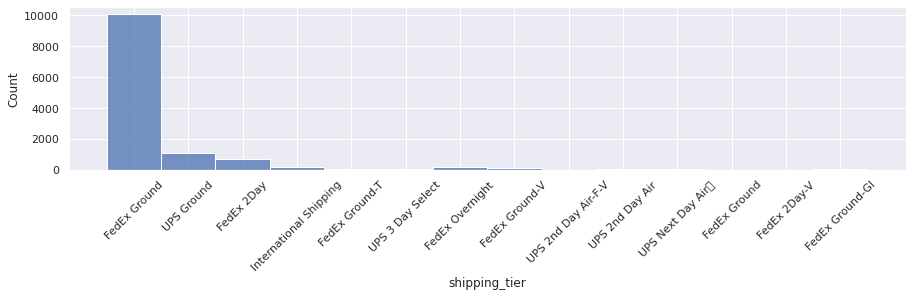

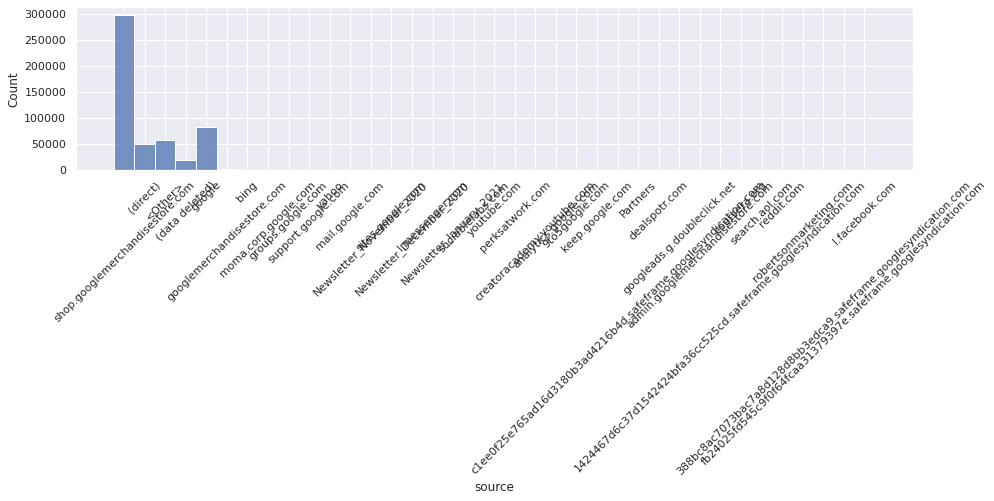

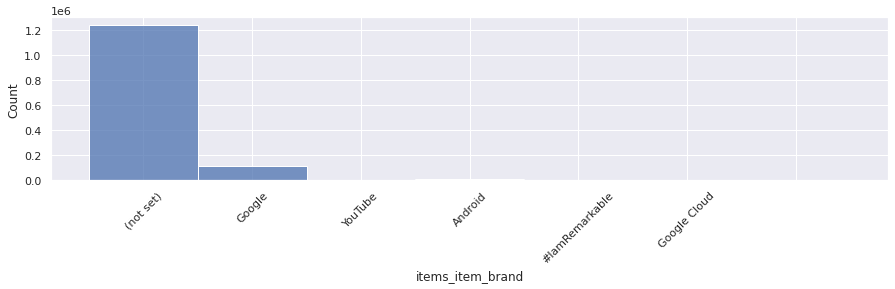

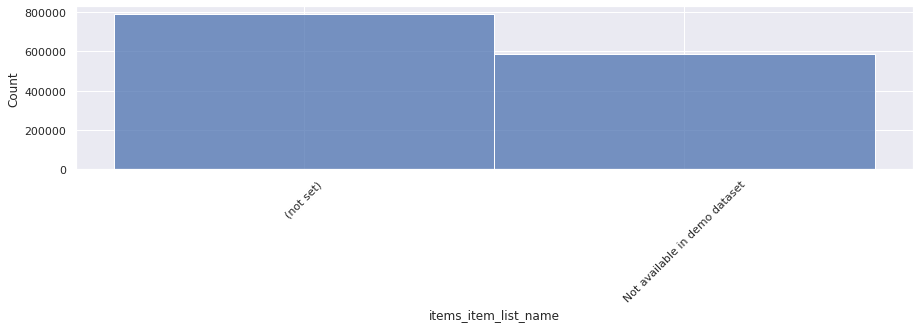

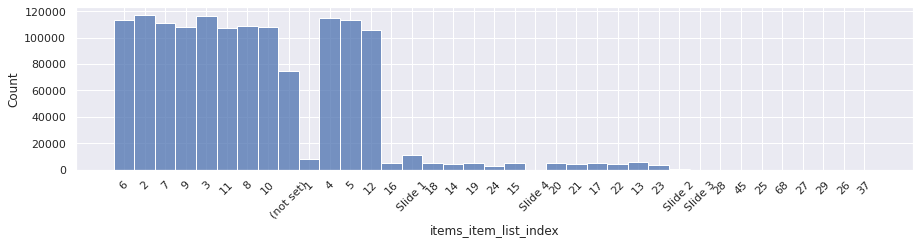

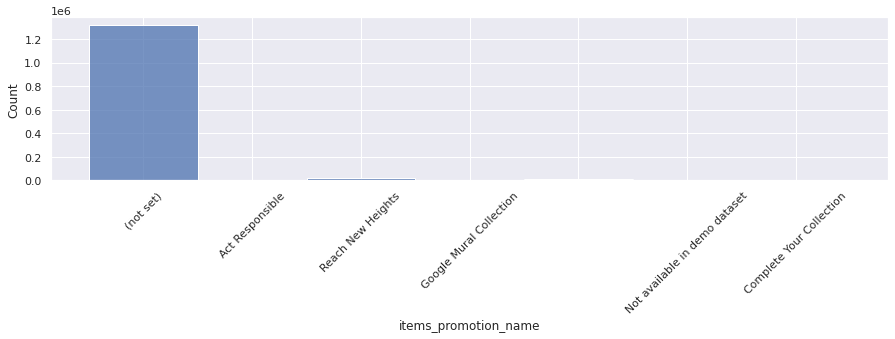

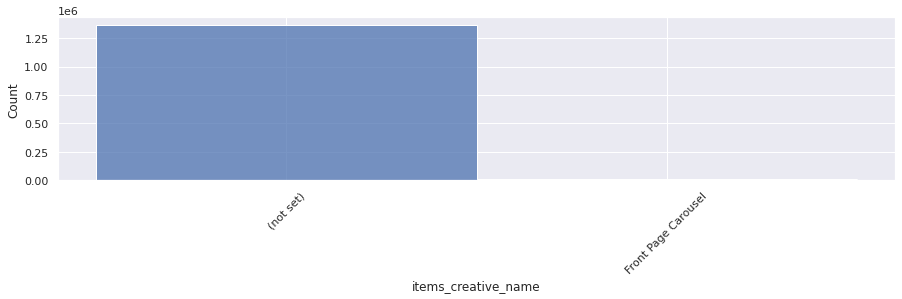

In [ ]:
# plot non-numeric features with <= 50 unique values
nunique = df[obj_col].nunique()
cols_to_plot = nunique[nunique <= 50].index

for col in cols_to_plot:
    plt.figure(figsize=(15,3))
    sns.histplot(data = df,x = col)
    plt.xticks(rotation=45)
    plt.show();

Everything looks as expected in the above features. We'll likely change or remove some with a large number of unique values later.

### Inspect remaining obj columns before saving table back to BQ

In [ ]:
# get list of remaining features in obj_col
nunique = df[obj_col].nunique()
cols_fifty_plus = nunique[nunique > 50].index

In [ ]:
df[cols_fifty_plus].head()

,pk,event_date,user_pseudo_id,geo_country,geo_region,geo_city,ecommerce_transaction_id,foreign_key,ga_session_id,page_location,page_referrer,page_title,items_item_id,items_item_name,items_item_variant,items_item_category,items_item_list_id
0,1604875726214575|view_item,20201108,49774767.6772681723,India,Uttar Pradesh,Ghaziabad,(not set),1604875726214575|view_item,3443194577.0,https://shop.googlemerchandisestore.com/Google...,https://shop.googlemerchandisestore.com/?,Hats | Apparel | Google Merchandise Store,GGOEAHPL130910,Android Iconic Hat Green,(not set),Home/Apparel/Hats/,(not set)
1,1608050245030626|view_item,20201215,49882860.4695240275,United States,California,Sacramento,(not set),1608050245030626|view_item,469714960.0,https://shop.googlemerchandisestore.com/Google...,https://shop.googlemerchandisestore.com/Google...,Google | Shop by Brand | Google Merchandise Store,GGOEGAPH161899,Google Land & Sea Cotton Cap,(not set),Home/Shop by Brand/Google/,(not set)
2,1607468370653037|view_item,20201208,50054690.0206427992,Thailand,(not set),(not set),(not set),1607468370653037|view_item,4056181347.0,https://shop.googlemerchandisestore.com/Google...,None,New | Google Merchandise Store,GGCOGBJD157199,Google Land & Sea Tote Bag,(not set),Home/New/,(not set)
3,1606765393421921|view_item,20201130,50121199.4323445332,Canada,Ontario,Vaughan,(not set),1606765393421921|view_item,3064953396.0,https://shop.googlemerchandisestore.com/store....,https://shop.googlemerchandisestore.com/Google...,Home,GGOEGAKA126399,Google Mural Sticker Sheet,(not set),Lifestyle/,(not set)
4,1609305516767732|view_item,20201230,50361845.1840834873,Indonesia,Jakarta,Jakarta,(not set),1609305516767732|view_item,2879039041.0,https://shop.googlemerchandisestore.com/Google...,https://shop.googlemerchandisestore.com/?,Sale | Google Merchandise Store,GGOEGOCL092999,Google Small Standard Journal Navy,(not set),Home/Sale/,(not set)


### Statistical summary of the table
Inspect a statistical summary of the dataframe, and all data types, one last time before saving to BQ and moving to the next notebook.

In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pk,2002257,778146,1607919975292661|purchase,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_date,2002257,92,20201211,70430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_timestamp,2002257.000,NaN,NaN,NaN,-4354441891106.153,1942855150245.805,1604189395117321.000,1606665482059758.000,1607661616825306.000,1608899106007254.000,1612136276965135.000
event_name,2002257,16,view_item,906923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_value_in_usd,15555.000,NaN,NaN,NaN,105.502,115.927,1.000,41.000,73.000,133.000,1530.000
event_bundle_sequence_id,2002257.000,NaN,NaN,NaN,-5110256.172,5766806254.479,-9999995056.000,-5000668771.000,-22886970.000,4981346153.000,9999982755.000
user_pseudo_id,2002257,4419,3198843.0611848527,4097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_first_touch_timestamp,1957434.000,NaN,NaN,NaN,3625739304016.823,5199400147370.929,1572069360071944.000,1604769885625649.000,1606908573383452.000,1608127618513394.000,1612132601258613.000
user_ltv_revenue,2002257.000,NaN,NaN,NaN,21.615,72.885,0.000,0.000,0.000,0.000,1530.000
device_category,2002257,3,desktop,1148911,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dtypes

pk                                    object
event_date                            object
event_timestamp                        Int64
event_name                            object
event_value_in_usd                   float64
event_bundle_sequence_id               Int64
user_pseudo_id                        object
user_first_touch_timestamp             Int64
user_ltv_revenue                     float64
device_category                       object
device_mobile_brand_name              object
device_mobile_model_name              object
device_operating_system               object
device_operating_system_version       object
device_language                       object
device_web_info_browser               object
device_web_info_browser_version       object
geo_continent                         object
geo_sub_continent                     object
geo_country                           object
geo_region                            object
geo_city                              object
traffic_so

In [ ]:
# finally, drop any remaining columns we identified as unnecessary in the previous notebook
df.drop("event_bundle_sequence_id",axis=1,inplace=True)

## Save df to BigQuery

In [ ]:
client = bigquery.Client(project = project_name)
table_id = 'public_sample_data.churn_ga4_2'
    
job_config = bigquery.LoadJobConfig(
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df, table_id, job_config = job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=d5a0a970-dc5b-4f2b-9518-872278f85978>